In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

from datasets import FullyAnnotatedDataset, WeaklyAnnotatedDataset
from main import train_model
from UNet import MultitaskAttentionUNet
from utils import visualize_predictions

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
X = np.load('data/X.npy') 
masks = np.load('data/masks.npy') 
boxes = np.load('data/y_centroids.npy')
y_class = np.load('data/y_class.npy')

In [4]:
X_weak = np.load('data/images.npy')
y_train_weak = np.load('data/labels.npy')

In [5]:
X_train, X_val, masks_train, masks_val, boxes_train, boxes_val, y_train, y_val = train_test_split(
        X , masks, boxes, y_class,
        test_size=0.2, random_state=42, shuffle=True
)

In [6]:
annotated_dataset = FullyAnnotatedDataset(X_train, masks_train, boxes_train, y_train, transform=None)

weak_dataset = WeaklyAnnotatedDataset(X_weak, y_train_weak, transform=None)

val_dataset = FullyAnnotatedDataset(X_val, masks_val, boxes_val, y_val, transform=None)

In [7]:
annotated_loader = DataLoader(annotated_dataset, batch_size=64, shuffle=True, num_workers=4)

weak_loader = DataLoader(weak_dataset, batch_size=64, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [8]:
model = MultitaskAttentionUNet(input_channels=1, num_classes=2, bbox_size=4).to(device)

model = MultitaskAttentionUNet_Pretrained(input_channels=1, num_classes=13, bbox_size=6).to(device)

In [9]:
train_model(model, annotated_loader, weak_loader, val_loader, device, num_epochs=2, patience=10, base_dir='./')

Epoch 1/2 - Validation:  14%|█▍        | 1/7 [00:11<01:09, 11.60s/it]


Epoch [1/2] Train Loss: 1.1144 (Seg: 0.4366, Cls: 0.6374, Loc: 0.0404) Val Loss: 1.4598 (Seg: 0.6902, Cls: 0.6938, Loc: 0.0758) Val Acc: 0.4922 Dice: 0.1018 IoU: 0.0509 Precision: 0.0000 Recall: 0.0000 F1: 0.0000 ROC-AUC: 0.4753 MAE: 0.2795
Best model saved!


Epoch 2/2 - Validation:  14%|█▍        | 1/7 [00:09<00:59,  9.88s/it]


Epoch [2/2] Train Loss: 0.9664 (Seg: 0.3933, Cls: 0.5495, Loc: 0.0236) Val Loss: 1.4238 (Seg: 0.6535, Cls: 0.6972, Loc: 0.0731) Val Acc: 0.4922 Dice: 0.1456 IoU: 0.0728 Precision: 0.0000 Recall: 0.0000 F1: 0.0000 ROC-AUC: 0.5472 MAE: 0.2696
Best model saved!


In [9]:
model.load_state_dict(torch.load(os.path.join('./', 'best_model.pth'), weights_only=True))
model.to(device)

MultitaskAttentionUNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

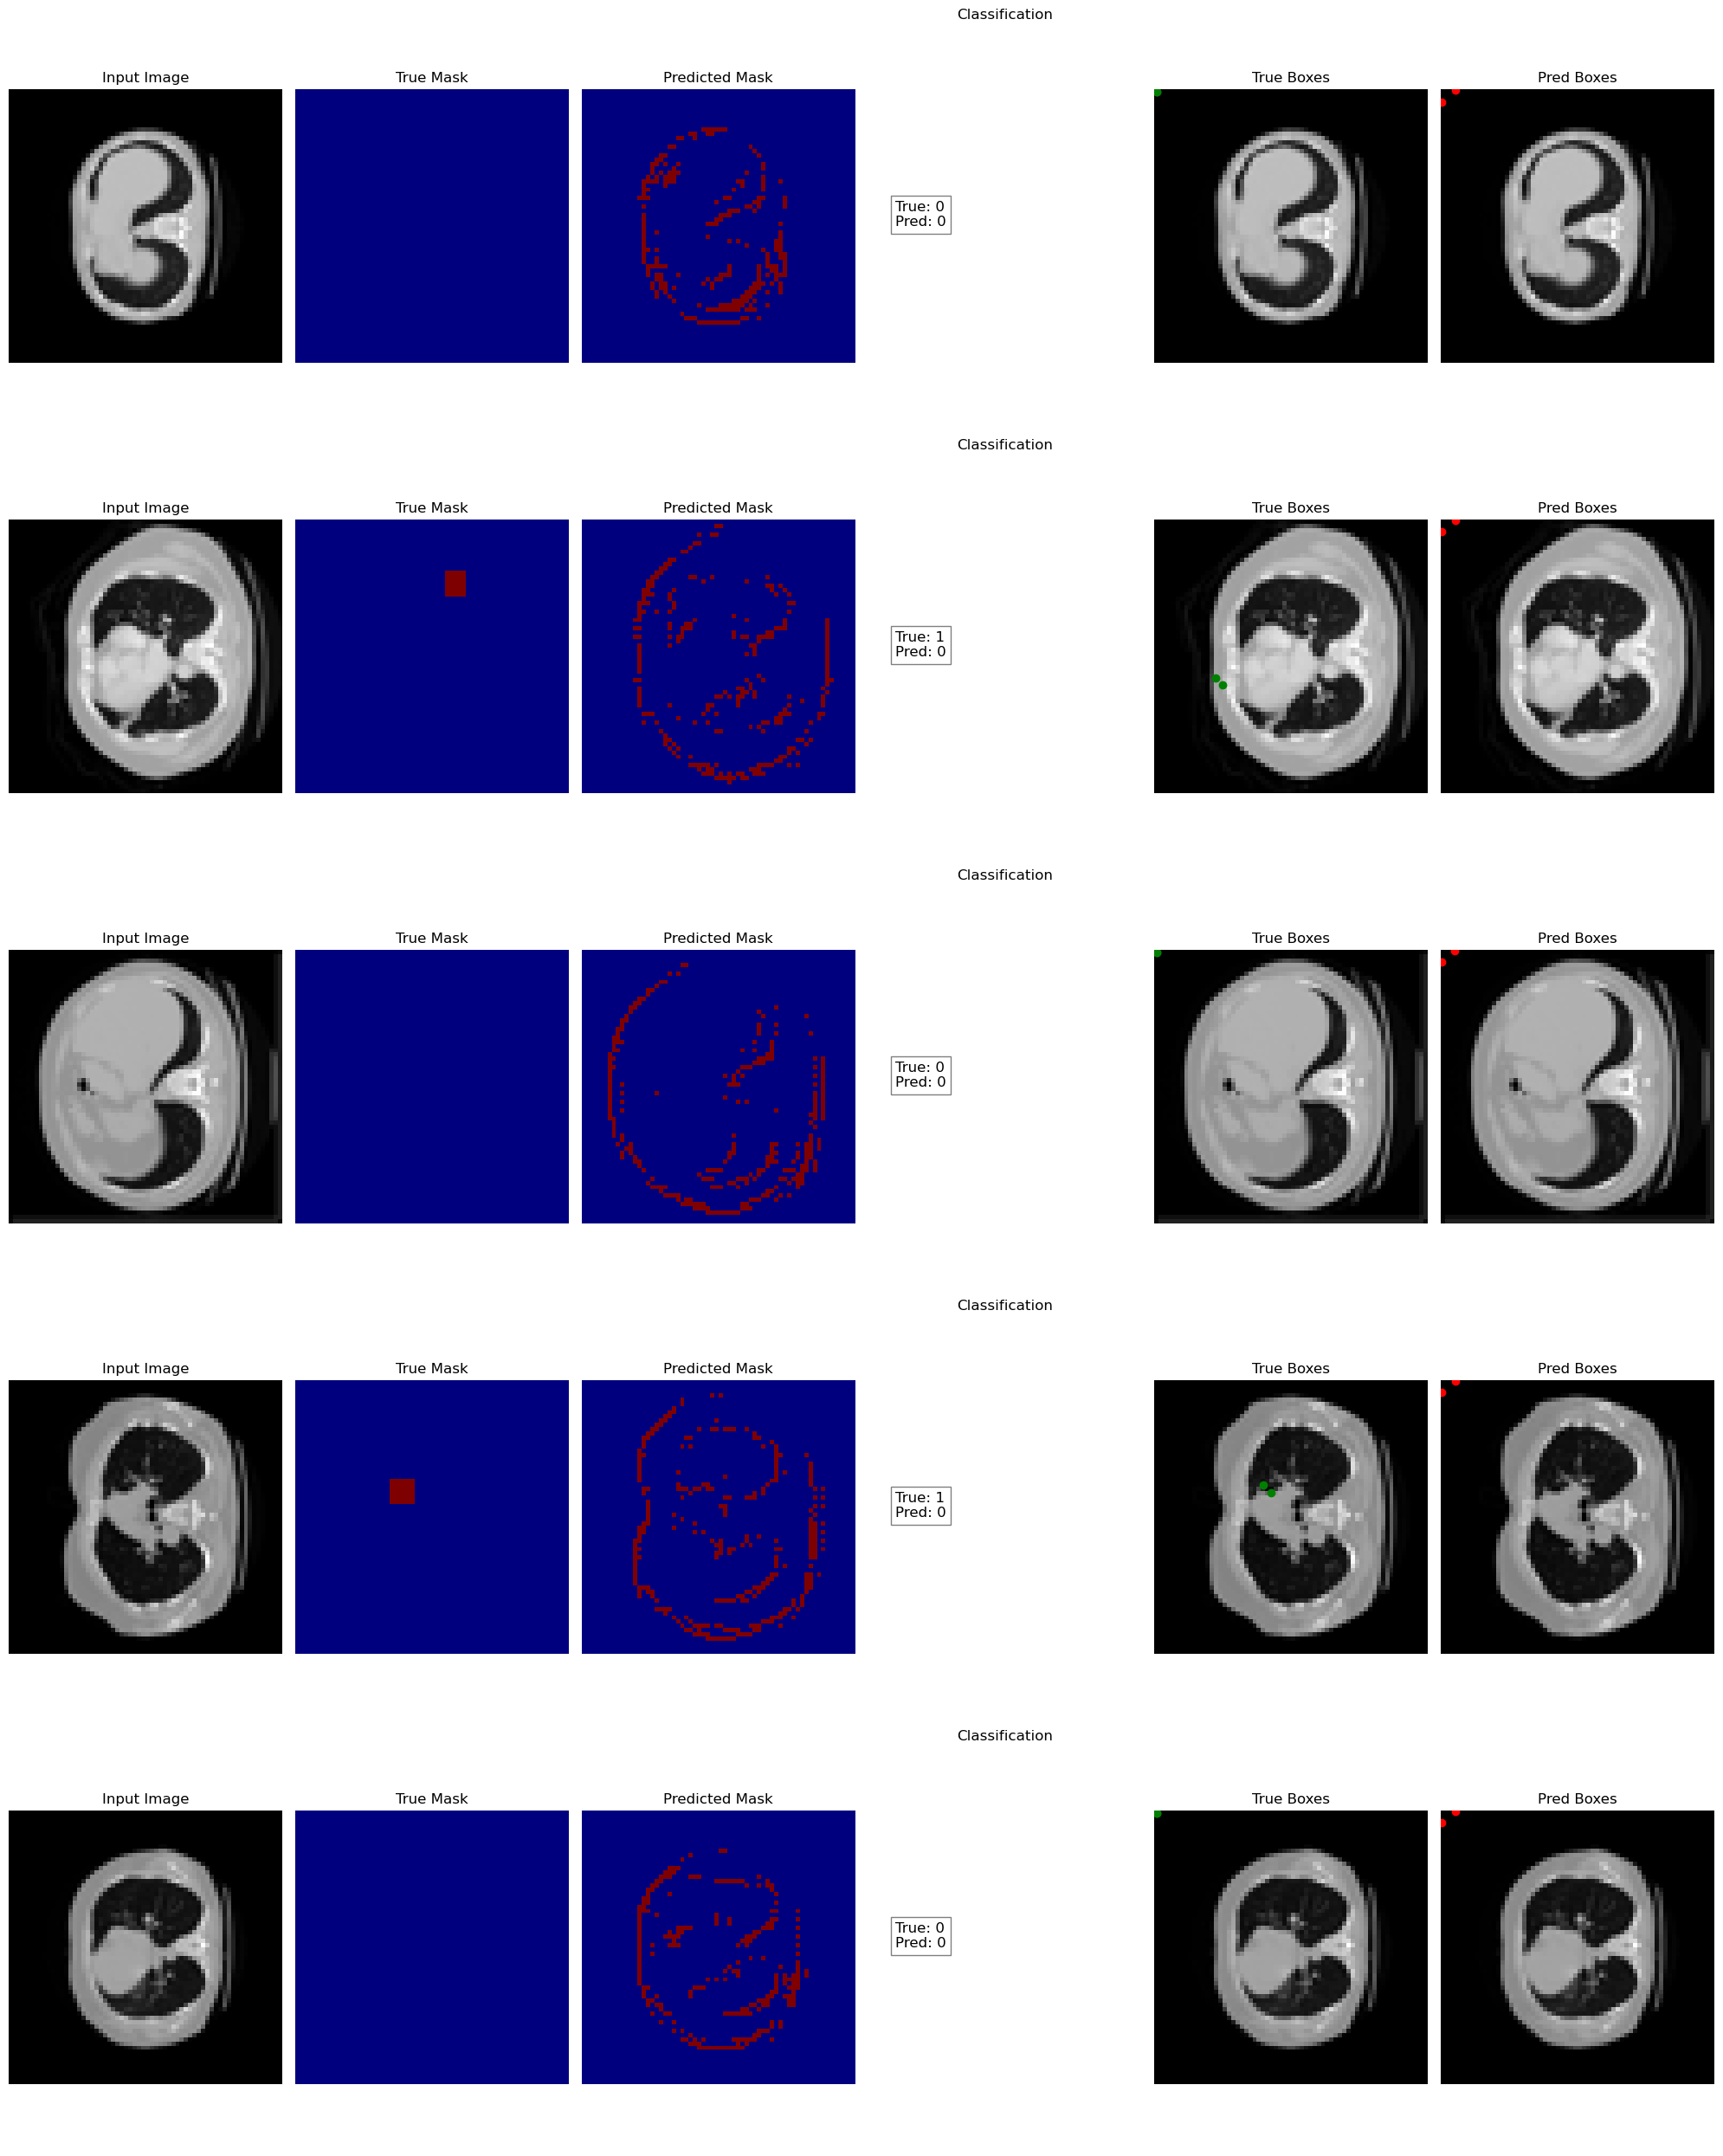

In [10]:
visualize_predictions(model, val_loader, device, num_samples=5, num_classes=2)